In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import warnings

warnings.filterwarnings("ignore")


# load data
weather = pd.read_csv("climatedatawithdate.csv")
weather.head()


,puttalam,tauu,rlus,sfcWind,rsuscs,rsus,rsdscs,prw,hurs,rtmt,...,tasmax,tasmin,tauv,tro3_500,tro3_850,ts,uas,wap_850,zg_850,date
0,63.3,0.152785,0.142045,0.477828,0.454995,0.497287,0.322817,0.440015,0.638365,0.298824,...,0.135349,0.221053,0.224634,0.673354,0.863010,0.147308,0.130948,0.736840,0.739986,1/1/1980
1,65.8,0.160138,0.264588,0.367296,0.726774,0.744863,0.662825,0.319734,0.468713,0.599960,...,0.374378,0.241274,0.308724,0.710253,0.673910,0.286245,0.128115,0.909573,0.615100,2/1/1980
2,101.1,0.244791,0.591772,0.126316,0.988048,0.980332,0.980188,0.177955,0.008800,0.629573,...,0.728056,0.390637,0.452436,0.705782,0.774462,0.631751,0.235086,0.537343,0.570181,3/1/1980
3,247.1,0.492494,0.779492,0.319731,0.857485,0.641255,0.986357,0.480825,0.305399,0.768145,...,0.744221,0.743645,0.677382,0.514572,0.602426,0.784966,0.583027,0.433170,0.519760,4/1/1980
4,93.7,0.659536,0.821613,0.617099,0.633129,0.734383,0.829791,0.406790,0.416917,0.681049,...,0.836437,0.786981,0.815424,0.997094,0.698438,0.828084,0.768470,0.795436,0.402319,5/1/1980


In [ ]:
weather.isna().sum().sum()

0

In [ ]:
# Create a target column
weather['date'] = pd.to_datetime(weather['date'])  # Convert 'Date' column to DateTime format
weather.sort_values(by='date', inplace=True)

weather['target'] = weather['puttalam'].shift(-1)
weather.dropna(inplace=True)        # Drop the last row
weather.head()


,puttalam,tauu,rlus,sfcWind,rsuscs,rsus,rsdscs,prw,hurs,rtmt,...,tasmin,tauv,tro3_500,tro3_850,ts,uas,wap_850,zg_850,date,target
0,63.3,0.152785,0.142045,0.477828,0.454995,0.497287,0.322817,0.440015,0.638365,0.298824,...,0.221053,0.224634,0.673354,0.863010,0.147308,0.130948,0.736840,0.739986,1980-01-01,65.8
1,65.8,0.160138,0.264588,0.367296,0.726774,0.744863,0.662825,0.319734,0.468713,0.599960,...,0.241274,0.308724,0.710253,0.673910,0.286245,0.128115,0.909573,0.615100,1980-02-01,101.1
2,101.1,0.244791,0.591772,0.126316,0.988048,0.980332,0.980188,0.177955,0.008800,0.629573,...,0.390637,0.452436,0.705782,0.774462,0.631751,0.235086,0.537343,0.570181,1980-03-01,247.1
3,247.1,0.492494,0.779492,0.319731,0.857485,0.641255,0.986357,0.480825,0.305399,0.768145,...,0.743645,0.677382,0.514572,0.602426,0.784966,0.583027,0.433170,0.519760,1980-04-01,93.7
4,93.7,0.659536,0.821613,0.617099,0.633129,0.734383,0.829791,0.406790,0.416917,0.681049,...,0.786981,0.815424,0.997094,0.698438,0.828084,0.768470,0.795436,0.402319,1980-05-01,0.4


## Data preprocessing

In [ ]:
# Checking Constant Features using VarianceThreshold

from sklearn.feature_selection import VarianceThreshold

numeric_data = weather.drop(['date'], axis=1)
constant_filter = VarianceThreshold(threshold=0)

#Fit and transforming on train data
data_constant = constant_filter.fit_transform(numeric_data)
print(data_constant.shape)

#Extracting all constant columns using get support function of our filter
constant_columns = [column for column in numeric_data.columns
                    if column not in numeric_data.columns[constant_filter.get_support()]]

#No. of constant columns
print(len(constant_columns))

#Constant columns names:
for column in constant_columns:
    print(column)

(431, 50)
0


In [ ]:
# Checking Quasi-Constant Features

qcons_filter = VarianceThreshold(threshold=0.01)

#Fit and transforming on train data
data_qcons = qcons_filter.fit_transform(numeric_data)
print(data_qcons.shape)

#Extracting all Quasi constant columns using get support function of our filter
qcons_columns = [column for column in numeric_data.columns
                    if column not in numeric_data.columns[qcons_filter.get_support()]]

#No. of Quasi constant columns
print(len(qcons_columns))

#Quasi Constant columns names:
for column in qcons_columns:
    print(column)

(431, 50)
0


## Feature importances

In [ ]:
# split train and test data
# train = weather[weather['date'] < pd.to_datetime("1/1/2006")]
# test = weather[weather['date'] > pd.to_datetime("1/1/2006")]

# X = weather.drop(['date', 'puttalam', 'target'], axis=1)
# y = weather['target']

weather4 = weather.copy()

X_train =  weather4[weather4['date'] < pd.to_datetime("1/1/2006")].drop(['date', 'target'], axis=1)
y_train = weather4[weather4['date'] < pd.to_datetime("1/1/2006")]['target']

X_test =  weather4[weather4['date'] > pd.to_datetime("1/1/2006")].drop(['date', 'target'], axis=1)
y_test = weather4[weather4['date'] > pd.to_datetime("1/1/2006")]['target']

In [ ]:
from sklearn.ensemble import RandomForestRegressor  # For regression tasks
from sklearn.ensemble import RandomForestClassifier  # For classification tasks
from xgboost import XGBRegressor, XGBClassifier  # XGBoost

# Example with Random Forest for regression
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
feature_importances = model.feature_importances_


In [ ]:
# For example, selecting the top 25 most important features
sorted_indices = feature_importances.argsort()[::-1]
selected_features = X_train.columns[sorted_indices[:30]]
selected_features

Index(['rsuscs', 'wap_850', 'tro3_500', 'sbl', 'puttalam', 'sfcWind', 'rtmt',
       'va_500', 'tro3_850', 'rsds', 'rsutcs', 'rsdt', 'ta_850', 'rsus',
       'hurs', 'rsdscs', 'clwvi', 'hfss', 'ua_500', 'va_850', 'ta_500', 'clt',
       'zg_850', 'hfls', 'clivi', 'rlutcs', 'prc', 'zg_500', 'prw', 'evspsbl'],
      dtype='object')

## XGB

In [ ]:
# Apply xgb
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train[selected_features], y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
y_pred = model.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
mse

6982.558648526843

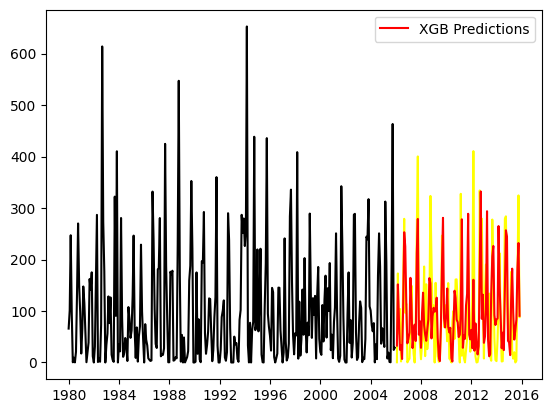

In [ ]:
# plotting
train_dates = weather4[weather4['date'] < pd.to_datetime("1/1/2006")]['date']
test_dates = weather4[weather4['date'] > pd.to_datetime("1/1/2006")]['date']

plt.plot(train_dates, y_train.values, color="black")
plt.plot(test_dates, y_test.values, color="yellow")
plt.plot(test_dates, y_pred, color='red', label = 'XGB Predictions')

plt.legend()

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest regressor with your desired hyperparameters
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train[selected_features], y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = model.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
mse

4943.850279381355

## ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

ARIMAmodel = ARIMA(y_train, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
y_pred = model.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
mse

4943.850279381355

In [ ]:
train_data = weather4[weather4['date'] < pd.to_datetime("1/1/2006")]
test_data = weather4[weather4['date'] > pd.to_datetime("1/1/2006")]

y_train = train_data['target']
y_test = test_data['target']


In [ ]:
import pmdarima as pm
import statsmodels.api as sm

# Perform auto ARIMA to determine p, d, and q
model = pm.auto_arima(y_train, start_p=1, start_d=1, start_q=1,
                      max_p=3, max_d=2, max_q=3,
                      seasonal=False, stepwise=True, trace=True, error_action='ignore',
                      suppress_warnings=True)

# Get the best ARIMA order
order = model.order


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3889.793, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4013.713, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3889.529, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3926.824, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3890.129, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3818.485, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3836.408, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3810.499, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3790.732, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3790.630, Time=0.42 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3796.439, Time=0.30 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3746.343, Time=0.62 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=i

In [ ]:
# Build and fit the ARIMA model
arima_model = sm.tsa.ARIMA(y_train, order=order)
arima_results = arima_model.fit()


In [ ]:
y_pred_arima = arima_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, typ='levels')


In [ ]:
mse_arima = mean_squared_error(y_test, y_pred_arima)
print(f"ARIMA MSE: {mse_arima}")


ARIMA MSE: 8811.795365936609


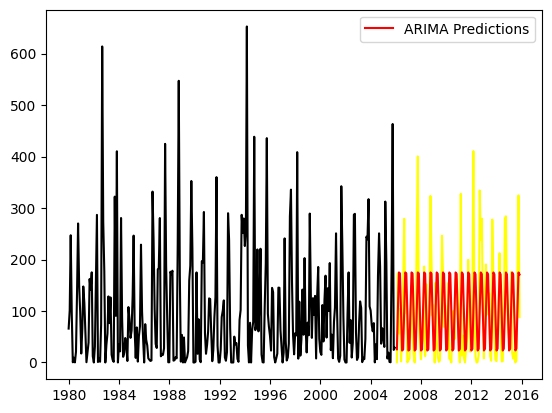

In [ ]:
plt.plot(train_data['date'], y_train.values, color="black")
plt.plot(test_data['date'], y_test.values, color="yellow")
plt.plot(test_data['date'], y_pred_arima, color='red', label='ARIMA Predictions')

plt.legend()
plt.show()


hyperparameter tuning

In [ ]:
import pmdarima as pm

# Perform auto ARIMA to determine the best order
model = pm.auto_arima(y_train, seasonal=True, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True)

# Get the best ARIMA order
best_order = model.order

print(f"Best ARIMA Order: {best_order}")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3836.408, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3818.485, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3814.940, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4013.713, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3816.920, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3816.842, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3817.840, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3926.824, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.450 seconds
Best ARIMA Order: (0, 0, 1)


In [ ]:
import statsmodels.api as sm

# Define SARIMA order
p, d, q = 0, 0, 1  # Non-seasonal order
P, D, Q, s = 0, 0, 1, 12  # Seasonal order with s=12 for monthly data

# Build and fit the SARIMA model
sarima_model = sm.tsa.SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_results = sarima_model.fit()

# Make predictions on the test data
y_pred_sarima = sarima_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Calculate MSE
mse_sarima = mean_squared_error(y_test, y_pred_sarima)
print(f"SARIMA MSE: {mse_sarima}")


SARIMA MSE: 18497.066543204917
